In [680]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries

# Eccentric TEOBResumS waveform

In [422]:
# Mass parameters
M1 = 36 # Mo
M2 = 29 # Mo

# Use 22 mode only
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
k = modes_to_k([[2,2]])
print(k)

[1]


In [4]:
# Define a dictionary with input parameters
pars = {
    'M'                  : 80,
    'q'                  : 2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,      # TD
    'arg_out'            : 1,      # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
    'initial_frequency'  : 20.,    # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 410,
    'inclination'        : 0,
    'ecc'                : 0.1,
    'ecc_freq'           : 20,
    'output_hpc'         : 0,
}

In [5]:
# Run the WF generator
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)

# Approximate merger time
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
print('tmrg = {}'.format(tmrg))
t = t - tmrg # shift to mrg

tmrg = 0.5490722656250001


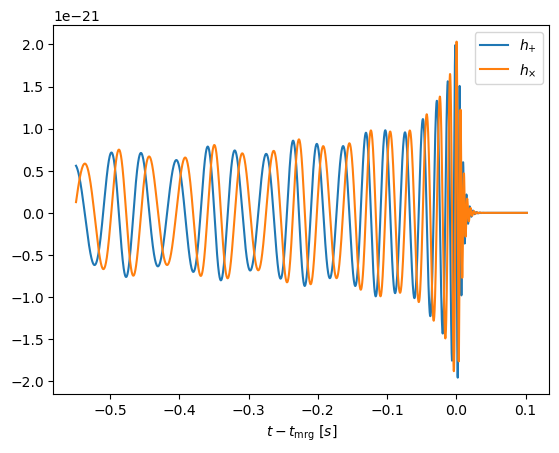

In [6]:
# Plot h
plt.plot(t, hp, label=r'$h_{+}$')
plt.plot(t, hc, label=r'$h_{\times}$')
#plt.xlim([0,0.05])
plt.xlabel(r'$t-t_{\rm mrg}$ $[s]$')
plt.legend()
plt.show()

# Match with other waveforms


In [7]:
# Finds next highest power of two
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

In [14]:
# Global params
f_low = 20
sample_rate = 4096

In [9]:
# PyCBC waveform
sp, sc = get_td_waveform(approximant="EccentricTD",
                         mass1=40,
                         mass2=20,
                         eccentricity=0.2,
                         f_ref=20,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

In [15]:
# TEOBResumS waveform
m1 = 40
m2 = 20
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 1,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : 0.2,
    'ecc_freq'           : 20,
    'output_hpc'         : 0,
}
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

The match is: 0.4017


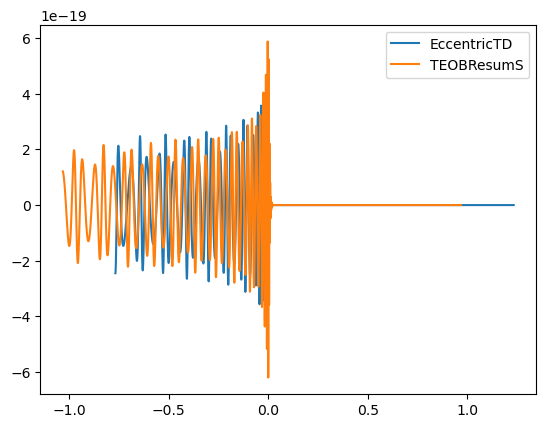

In [11]:
# Resize the waveforms to the same length
tlen = ceiltwo(max(len(sp), len(hp)))
sp.resize(tlen)
hp.resize(tlen)
sc.resize(tlen)
hc.resize(tlen)

plt.plot(sp.sample_times, sp, label='EccentricTD')
plt.plot(hp.sample_times, hp, label='TEOBResumS')
plt.legend()
#plt.xlim(-1,0.1)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
print('The match is: {:.4f}'.format(m))

# Useful functions

In [687]:
# Generates EccentricTD waveform with given parameters
def gen_e_td_wform(M, q, e, f):
    m2 = M / (1+q)
    m1 = M - m2
    e_td_p, e_td_c = get_td_waveform(approximant='EccentricTD',
                                     mass1=m1,
                                     mass2=m2,
                                     eccentricity=e,
                                     delta_t=1.0/sample_rate,
                                     f_lower=f)
    return e_td_p, e_td_c

In [689]:
def match_ts(match_1, match_2, f, subsample_interpolation=True):
    
    # Resize the waveforms to the same length
    tlen = ceiltwo(max(len(match_1), len(match_2)))
    match_1.resize(tlen)
    match_2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / match_1.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f)

    # Perform match
    m, _ = match(match_1, match_2, psd=psd, low_frequency_cutoff=f, subsample_interpolation=subsample_interpolation)

    return m

# Mass vs eccentricity

In [2]:
# Global params
f_low = 20
sample_rate = 4096

# Modes to use
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

# Finds next highest power of two
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

In [77]:
# Waveform to match to
m1 = 20
m2 = 10
ecc = 0.1
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'ecc_freq'           : f_low,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

In [78]:
# Create grid of values
e_vals = np.linspace(0, 0.2, 11, endpoint=True)
M_vals = np.linspace(29, 31, 11, endpoint=True)
gridsize = len(e_vals)*len(M_vals)

# Saves fiducial params to be reset afterwards
fiducial_vals = {'ecc':pars['ecc'], 'M':pars['M']}

# Calculate match for each point on grid
match_vals = []
progress = 0
for e in e_vals:
    match_vals.append([])
    for M in M_vals:
        
        # Create waveform to match
        pars.update({'M':M,'ecc':e})
        t, sp, sc = EOBRun_module.EOBRunPy(pars)
        s = sp - 1j*sc
        tmrg = t[np.argmax(np.abs(s))]
        t = t - tmrg
        sp = timeseries.TimeSeries(sp, np.mean(np.diff(t)), epoch=t[0])
        sc = timeseries.TimeSeries(sc, np.mean(np.diff(t)), epoch=t[0])
        
        # Resize the waveforms to the same length
        tlen = ceiltwo(max(len(sp), len(hp)))
        sp.resize(tlen)
        hp.resize(tlen)
        
        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration
        flen = tlen//2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        
        # Perform match
        m, _ = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
        match_vals[-1].append(m)
        progress += 1
        if progress%10 == 0 or progress == gridsize:
            print(f'{progress} done out of {gridsize}')

# Resets pars to fiducial parameters
pars.update(fiducial_vals)

10 done out of 121
20 done out of 121
30 done out of 121
40 done out of 121
50 done out of 121
60 done out of 121
70 done out of 121
80 done out of 121
90 done out of 121
100 done out of 121
110 done out of 121
120 done out of 121
121 done out of 121


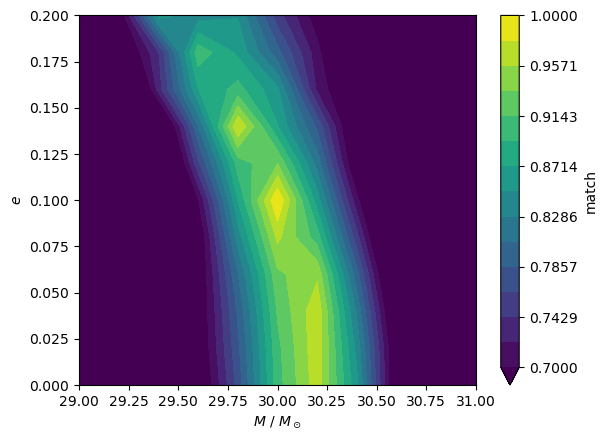

In [79]:
# Make contour plot
plt.contourf(M_vals, e_vals, match_vals, np.linspace(0.7, 1, 15), vmin=0.7, vmax=1, extend='min')
plt.xlabel('$M~/~M_\odot$')
plt.ylabel('$e$')
plt.colorbar(label='match')

## Fix oscillations

In [4]:
# Calculates component masses from total mass and mass ratio
def m1_m2_from_M_q(M, q):
    m2 = M/(1+q)
    m1 = M - m2
    return m1, m2

In [5]:
# Calculates orbital period from gw frequency
def P_from_f(f):
    f_orb = f/2
    return 1/f_orb

In [6]:
# Uses Kepler's 3rd to get semi-major axis from period of orbit
def a_from_P(P, M):
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

In [7]:
# Calculates periastron advance per orbital revolution
def peri_advance_orbit(P, e, M):
    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    
    return numerator/denominator

In [8]:
# Calculates number of orbits for true anomaly to shift by 2pi
def num_orbits(P, e, M):
    delta_phi = peri_advance_orbit(P, e, M)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

In [9]:
# How much frequency is shifted by per orbit
def delta_freq_orbit(P, e, M, q):
    m1, m2 = m1_m2_from_M_q(M, q)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

In [10]:
# Calculates what new shifted frequency should be such that true anomaly changes by 2pi
def shifted_f(f, e, M, q):
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit(P, e, M, q)
    n_orbit = num_orbits(P, e, M)
    return f - delta_f_orbit*n_orbit

In [11]:
# Calculates what new shifted frequency and eccentricity should be to shift such that true anomaly changes by 2pi
def shifted_e(s_f, f, e):
    s_e = e*(s_f/f)**(-19/18)
    return s_e

In [12]:
s_f = shifted_f(20, 0.1, 80, 2)
s_e = shifted_e(s_f, 20, 0.1)
print(s_f, s_e)

18.379222325430653 0.10933064554693822


In [97]:
# Waveform to match to
m1 = 20
m2 = 10
ecc = 0.1
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'ecc_freq'           : f_low,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

In [98]:
e_len = 11
M_len = 11
s_f_len = 11
gridsize = e_len*M_len*s_f_len

# Create grid of values
e_vals = np.linspace(0, 0.2, e_len, endpoint=True)
M_vals = np.linspace(29, 31, M_len, endpoint=True)

# Saves fiducial initial_frequency to calculate required shifts, and others to be reset afterwards
fiducial_vals = {'initial_frequency':pars['initial_frequency'], 'ecc':pars['ecc'], 'M':pars['M']}

# Calculate match for each point on grid
s_match_vals = []
progress = 0
for e in e_vals:
    s_match_vals.append([])
    for M in M_vals:

        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(fiducial_vals['initial_frequency'], e, M, pars['q'])
        s_f_vals = np.linspace(fiducial_vals['initial_frequency'], max_s_f, s_f_len, endpoint=False)
        s_f_matches = []
        for s_f in s_f_vals:

            # Create waveform to match
            s_e = shifted_e(s_f, fiducial_vals['initial_frequency'], e)
            pars.update({'initial_frequency': s_f, 'ecc': s_e, 'M':M})
            t, sp, sc = EOBRun_module.EOBRunPy(pars)
            s = sp - 1j*sc
            tmrg = t[np.argmax(np.abs(s))]
            t = t - tmrg
            sp = timeseries.TimeSeries(sp, np.mean(np.diff(t)), epoch=t[0])
            sc = timeseries.TimeSeries(sc, np.mean(np.diff(t)), epoch=t[0])

            # Resize the waveforms to the same length
            tlen = ceiltwo(max(len(sp), len(hp)))
            sp.resize(tlen)
            hp.resize(tlen)

            # Generate the aLIGO ZDHP PSD
            delta_f = 1.0 / sp.duration
            flen = tlen//2 + 1
            psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

            # Perform match
            m, _ = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
            s_f_matches.append(m)

            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print(f'{progress} done out of {gridsize}')

        # Appends best match, optimisng over shifted frequency
        s_match_vals[-1].append(np.max(s_f_matches))
            
# Resets pars to fiducial parameters
pars.update(fiducial_vals)
print(pars)

10 done out of 1331
20 done out of 1331
30 done out of 1331
40 done out of 1331
50 done out of 1331
60 done out of 1331
70 done out of 1331
80 done out of 1331
90 done out of 1331
100 done out of 1331
110 done out of 1331
120 done out of 1331
130 done out of 1331
140 done out of 1331
150 done out of 1331
160 done out of 1331
170 done out of 1331
180 done out of 1331
190 done out of 1331
200 done out of 1331
210 done out of 1331
220 done out of 1331
230 done out of 1331
240 done out of 1331
250 done out of 1331
260 done out of 1331
270 done out of 1331
280 done out of 1331
290 done out of 1331
300 done out of 1331
310 done out of 1331
320 done out of 1331
330 done out of 1331
340 done out of 1331
350 done out of 1331
360 done out of 1331
370 done out of 1331
380 done out of 1331
390 done out of 1331
400 done out of 1331
410 done out of 1331
420 done out of 1331
430 done out of 1331
440 done out of 1331
450 done out of 1331
460 done out of 1331
470 done out of 1331
480 done out of 1331
4

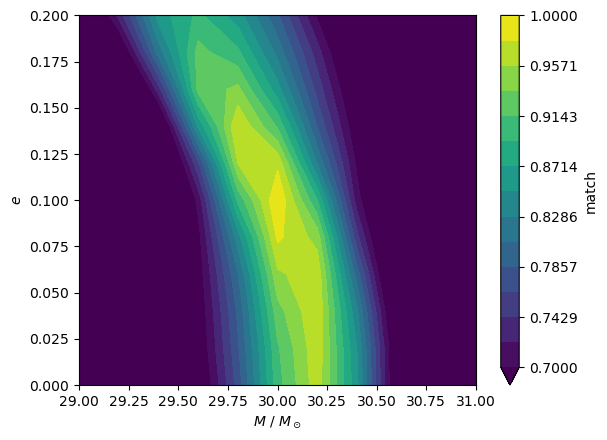

In [101]:
# Make contour plot
plt.contourf(M_vals, e_vals, s_match_vals, np.linspace(0.7, 1, 15), vmin=0.7, vmax=1, extend='min')
plt.xlabel('$M~/~M_\odot$')
plt.ylabel('$e$')
plt.colorbar(label='match')

# Shift frequency tests

In [376]:
# Waveform to match to
m1 = 20
m2 = 10
ecc = 0.1
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'ecc_freq'           : f_low,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

In [379]:
# Calculates match over range of intial frequency values
def optimise_s_f_match(pars, e_Ms, s_f_len):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if len(e_Ms) == 1:
        ax2 = ax1.twiny()
    
    gridsize = len(e_Ms)*s_f_len
    progress = 0
    for e, M in e_Ms:
    
        # Saves fiducial initial_frequency to calculate required shifts, and others to be reset afterwards
        fiducial_vals = {'initial_frequency':pars['initial_frequency'], 'ecc':pars['ecc'], 'M':pars['M']}
        
        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(fiducial_vals['initial_frequency'], e, M, pars['q'])
        s_f_vals = np.linspace(fiducial_vals['initial_frequency'], max_s_f, s_f_len, endpoint=True)
        s_e_vals = shifted_e(s_f_vals, fiducial_vals['initial_frequency'], e)
        s_f_matches = []
    
        # Loops over each initial frequency
        for s_f, s_e in zip(s_f_vals, s_e_vals):
    
            # Create waveform to match
            pars.update({'initial_frequency': s_f, 'ecc': s_e, 'M':M})
            t, sp, sc = EOBRun_module.EOBRunPy(pars)
            s = sp - 1j*sc
            tmrg = t[np.argmax(np.abs(s))]
            t = t - tmrg
            sp = timeseries.TimeSeries(sp, np.mean(np.diff(t)), epoch=t[0])
            sc = timeseries.TimeSeries(sc, np.mean(np.diff(t)), epoch=t[0])
        
            # Resize the waveforms to the same length
            tlen = ceiltwo(max(len(sp), len(hp)))
            sp.resize(tlen)
            hp.resize(tlen)
        
            # Generate the aLIGO ZDHP PSD
            delta_f = 1.0 / sp.duration
            flen = tlen//2 + 1
            psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        
            # Perform match
            m, _ = match(hp, sp, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
            s_f_matches.append(m)
        
            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print(f'{progress} done out of {gridsize}')
    
        # Resets pars to fiducial values
        print(fiducial_vals)
        pars.update(fiducial_vals)
        print(pars)
    
        # Makes plot
        ax1.plot(s_f_vals, s_f_matches, label=f'$e={e}$, $M={M}~M_\odot$')
        standard_length = shifted_f(pars['initial_frequency'], 0, pars['M'], pars['q'])
        print(s_f_matches[0])
        ax1.hlines(s_f_matches[0], standard_length, 20, colors='k')
        ax1.set_xlabel('Shifted frequency')
        if len(e_Ms) == 1:
            ax2.plot(s_e_vals, s_f_matches, alpha=0)
            ax2.invert_xaxis()
            ax2.set_xlabel('Shifted eccentricity')

    # Finish plot
    ax1.legend()
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={pars["ecc"]}$, $M={pars["M"]}~M_\odot$')

10 done out of 255
20 done out of 255
30 done out of 255
40 done out of 255
50 done out of 255
{'initial_frequency': 20, 'ecc': 0.1, 'M': 30}
{'M': 30, 'q': 2.0, 'Lambda1': 0.0, 'Lambda2': 0.0, 'chi1': 0.0, 'chi2': 0.0, 'domain': 0, 'arg_out': 0, 'use_mode_lm': [1], 'srate_interp': 4096, 'use_geometric_units': 0, 'initial_frequency': 20, 'interp_uniform_grid': 1, 'distance': 1, 'inclination': 0, 'ecc': 0.1, 'ecc_freq': 20, 'output_hpc': 0}
0.9052025557731159
60 done out of 255
70 done out of 255
80 done out of 255
90 done out of 255
100 done out of 255
{'initial_frequency': 20, 'ecc': 0.1, 'M': 30}
{'M': 30, 'q': 2.0, 'Lambda1': 0.0, 'Lambda2': 0.0, 'chi1': 0.0, 'chi2': 0.0, 'domain': 0, 'arg_out': 0, 'use_mode_lm': [1], 'srate_interp': 4096, 'use_geometric_units': 0, 'initial_frequency': 20, 'interp_uniform_grid': 1, 'distance': 1, 'inclination': 0, 'ecc': 0.1, 'ecc_freq': 20, 'output_hpc': 0}
0.9231361723554115
110 done out of 255
120 done out of 255
130 done out of 255
140 done out 

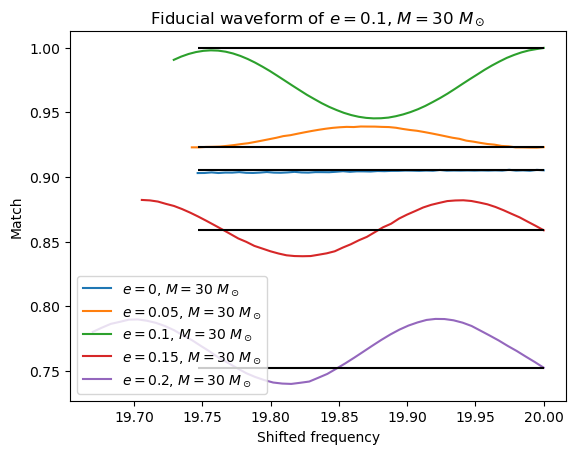

In [380]:
optimise_s_f_match(pars, [(0, 30), (0.05, 30), (0.1,30), (0.15, 30), (0.2, 30)], 51)

In [661]:
# Calculate sinusoidal curve paramaters from three points along it; y = a*sin(x+b)+c
# See https://math.stackexchange.com/questions/118526/fitting-a-sine-wave-of-known-frequency-through-three-points
def get_sinusoid_params(f_0, f_90, f_180):

    # Get constant offset
    c = 0.5*(f_0+f_180)

    # Get amplitude 
    a = np.sqrt((f_0-c)**2+(f_90-c)**2)

    # Get phase offset
    b = np.arctan2(f_0-c, f_90-c)

    return a, b, c

In [665]:
# Calculates sinusoid using parameters defined above
def calc_sinusoid(x, a, b, c):

    return a*np.sin(x+b)+c

In [736]:
# Calculates match over range of intial frequency values
def optimise_s_f_match_ecc_TD(fiducials, e_Ms, s_f_len, f_low, approx_sinusoidal=False, subsample_interpolation=True):

    # Generate fiducial waveform
    fiducial_p, fiducial_c = gen_e_td_wform(*fiducials, f_low)

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if len(e_Ms) == 1:
        ax2 = ax1.twiny()
    
    gridsize = len(e_Ms)*s_f_len
    progress = 0
    for e, M in e_Ms:
        
        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(f_low, e, M, fiducials[1])
        s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
        s_e_vals = shifted_e(s_f_vals, f_low, e)
        s_f_matches = []
    
        # Loops over each initial frequency
        for s_f, s_e in zip(s_f_vals, s_e_vals):
    
            # Create waveform to match
            hp, hc = gen_e_td_wform(M, fiducials[1], s_e, s_f)
            match = match_ts(fiducial_p, hp, s_f, subsample_interpolation=subsample_interpolation)
            s_f_matches.append(match)
        
            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')
    
        # Makes plot
        ax1.plot(s_f_vals, s_f_matches, label=f'$e={e}$, $M={M}~M_\odot$')
        ax1.set_xlabel('Shifted frequency')
        if len(e_Ms) == 1:
            ax2.plot(s_e_vals, s_f_matches, alpha=0)
            ax2.invert_xaxis()
            ax2.set_xlabel('Shifted eccentricity')

        if approx_sinusoidal:
            
            # Calculates sine wave approximation
            shift_2pi = np.abs(f_low - max_s_f)
            s_f_0 = f_low - shift_2pi/4
            s_f_180 = f_low + shift_2pi/4
            sinusoid_matches = []
            for s_f in [s_f_0, f_low, s_f_180]:

                s_e = shifted_e(s_f, f_low, e)
                
                # Create waveform to match
                hp, hc = gen_e_td_wform(M, fiducials[1], s_e, s_f)
                match = match_ts(fiducial_p, hp, s_f, subsample_interpolation=subsample_interpolation)
                sinusoid_matches.append(match)
                
            sinusoid_pars = list(get_sinusoid_params(*sinusoid_matches))
            sinusoid_pars[1] += np.pi/2 # Move defined zero of sinusoidal wave 'x' to be equivalent to f_low

            # Makes plot
            sinusoid_f_x = np.linspace(max_s_f, f_low, 101, endpoint=True)
            sinusoid_x = (sinusoid_f_x - f_low) * (2*np.pi/shift_2pi)
            plt.plot(sinusoid_f_x, calc_sinusoid(sinusoid_x, *sinusoid_pars), 'k:')

    # Finish plot
    ax1.legend()
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[2]}$, $M={fiducials[0]}~M_\odot$')

204 done out of 204

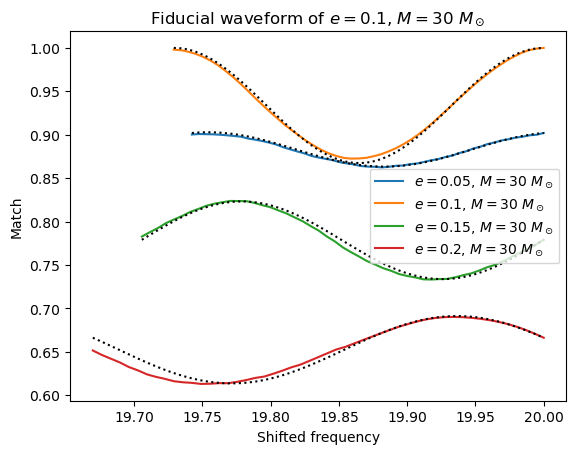

In [712]:
optimise_s_f_match_ecc_TD([30, 2, 0.1], [(0.05, 30), (0.1, 30), (0.15, 30), (0.2, 30)], 51, 20, approx_sinusoidal=True)

204 done out of 204

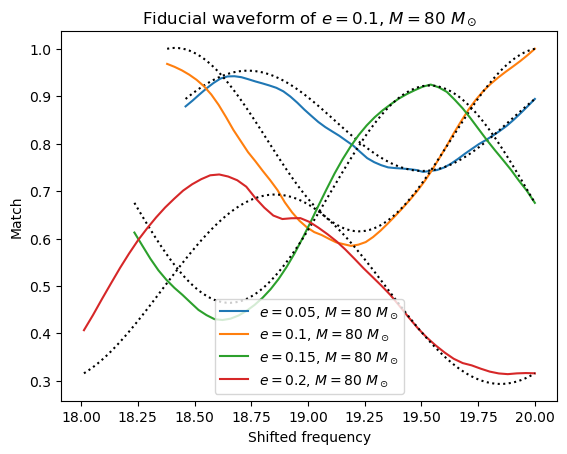

In [735]:
optimise_s_f_match_ecc_TD([80, 2, 0.1], [(0.05, 80), (0.1, 80), (0.15, 80), (0.2, 80)], 51, 20, approx_sinusoidal=True)

204 done out of 204

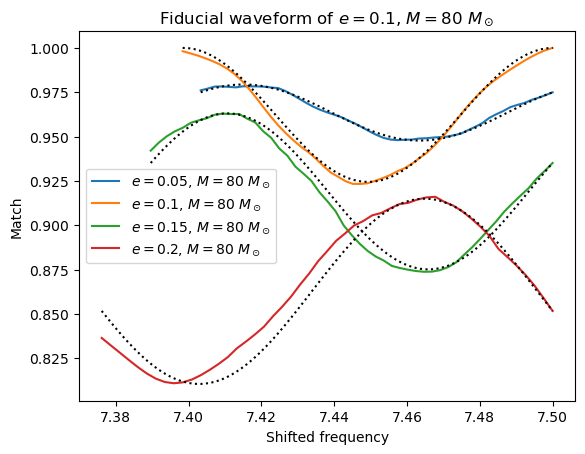

In [734]:
optimise_s_f_match_ecc_TD([80, 2, 0.1], [(0.05, 80), (0.1, 80), (0.15, 80), (0.2, 80)], 51, 7.5, approx_sinusoidal=True)

# Plotting shifted waveforms

In [558]:
def f_avg2peri(f_avg, M, e):
    
    a_kep_3 = const.G*M/(4*np.pi**2*f_avg**2)
    r_peri = (1-e)*a_kep_3**(1/3)
    f_peri_2 = const.G*M/(4*np.pi**2*r_peri**3)

    return f_peri_2**(1/2)

In [569]:
def f_avg2ap(f_avg, M, e):
    
    a_kep_3 = const.G*M/(4*np.pi**2*f_avg**2)
    r_ap = (1+e)*a_kep_3**(1/3)
    f_ap_2 = const.G*M/(4*np.pi**2*r_ap**3)

    return f_ap_2**(1/2)

In [559]:
def f_peri2avg(f_peri, M, e):

    r_peri_3 = const.G*M/(4*np.pi**2*f_peri**2)
    a_kep = r_peri_3**(1/3)/(1-e)
    f_avg_2 = const.G*M/(4*np.pi**2*a_kep**3)

    return f_avg_2**(1/2)

In [575]:
f_avg = 20
f_ap = f_avg2ap(f_avg, 30, 0.1)
f_peri = f_avg2peri(f_avg, 30, 0.1)
print(f_avg, (f_ap+f_peri)/2)

20 20.379981202519566


In [573]:
print(f_avg2peri(20, 30, 0.3))
print(f_peri2avg(20, 30, 0.3))

34.14938883812551
11.713240371477047


In [598]:
# Fiducial waveform
f_low=20
m1 = 20
m2 = 10
ecc = 0.3

In [596]:
# Waveform to match to
f_low_adjust = f_avg2peri(f_low, m1+m2, ecc)
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low, # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

In [589]:
# Generate shifted waveform
fiducial_vals = {'initial_frequency': pars['initial_frequency'], 'ecc': pars['ecc']}
s_f = shifted_f(pars['initial_frequency'], pars['ecc'], pars['M'], pars['q'])
s_e = shifted_e(s_f, pars['initial_frequency'], pars['ecc'])
print(s_f, s_e)
pars.update({'initial_frequency': s_f, 'ecc': s_e})
t, sp, sc = EOBRun_module.EOBRunPy(pars)
s = sp - 1j*sc
tmrg = t[np.argmax(np.abs(s))]
t = t - tmrg
sp = timeseries.TimeSeries(sp, np.mean(np.diff(t)), epoch=t[0])
sc = timeseries.TimeSeries(sc, np.mean(np.diff(t)), epoch=t[0])
pars.update(fiducial_vals)
print(pars)

19.729021690249603 0.10145035737463425
{'M': 30, 'q': 2.0, 'Lambda1': 0.0, 'Lambda2': 0.0, 'chi1': 0.0, 'chi2': 0.0, 'domain': 0, 'arg_out': 0, 'use_mode_lm': [1], 'srate_interp': 4096, 'use_geometric_units': 0, 'initial_frequency': 20, 'interp_uniform_grid': 1, 'distance': 1, 'inclination': 0, 'ecc': 0.1, 'output_hpc': 0}


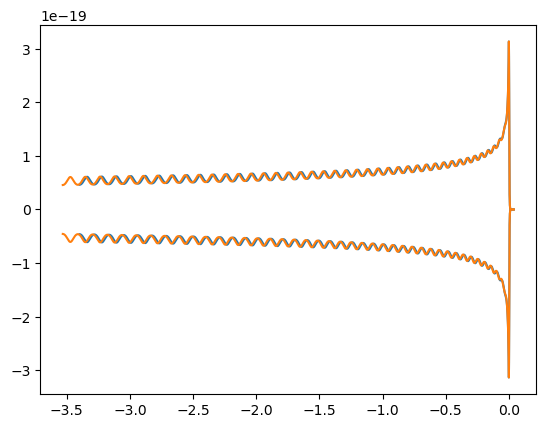

In [590]:
#plt.plot(hp.sample_times, hp)
plt.plot(hp.sample_times, np.sqrt(hp**2+hc**2), c='C0')
plt.plot(hp.sample_times, -np.sqrt(hp**2+hc**2), c='C0')
#plt.plot(sp.sample_times, sp)
plt.plot(sp.sample_times, np.sqrt(sp**2+sc**2), c='C1')
plt.plot(sp.sample_times, -np.sqrt(sp**2+sc**2), c='C1')
#plt.xlim(-5,-4)
#plt.ylim(0,1e-19)

In [730]:
# Fiducial waveform
f_low = 7.5
m1 = 160/3
m2 = 80/3
ecc = 0.1

In [731]:
# EccentricTD waveform to match to
hp2, hc2 = get_td_waveform(approximant='EccentricTD',
                         mass1=m1,
                         mass2=m2,
                         eccentricity=ecc,
                         delta_t=1.0/sample_rate,
                         f_lower=f_low)

In [732]:
# Generate shifted EccentricTD waveform
s_f = shifted_f(f_low, ecc, m1+m2, m1/m2)
s_e = shifted_e(s_f, f_low, ecc)
sp2, sc2 = get_td_waveform(approximant='EccentricTD',
                         mass1=m1,
                         mass2=m2,
                         eccentricity=s_e,
                         delta_t=1.0/sample_rate,
                         f_lower=s_f)

Match of 0.9981323603051266


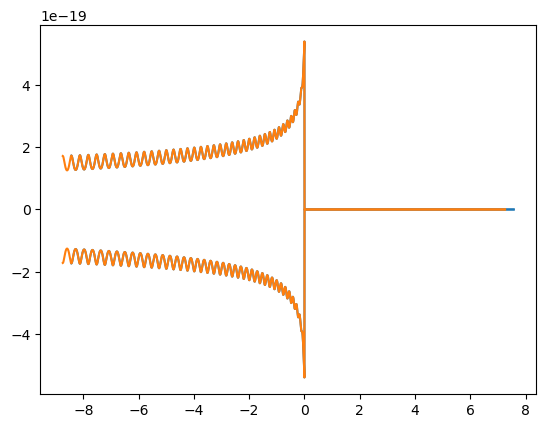

In [733]:
# Resize the waveforms to the same length
tlen = ceiltwo(max(len(sp2), len(hp2)))
sp2.resize(tlen)
hp2.resize(tlen)
sc2.resize(tlen)
hc2.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp2.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Perform match
m, _ = match(hp2, sp2, psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=True)
print(f'Match of {m}')

# Plot EccentricTD waveform envelopes
plt.plot(hp2.sample_times, np.sqrt(hp2**2+hc2**2), c='C0')
plt.plot(hp2.sample_times, -np.sqrt(hp2**2+hc2**2), c='C0')
plt.plot(sp2.sample_times, np.sqrt(sp2**2+sc2**2), c='C1')
plt.plot(sp2.sample_times, -np.sqrt(sp2**2+sc2**2), c='C1')
#plt.xlim(-16, -14)

# Fourier decomposition

In [497]:
def compute_fft(t, x):
    signal = np.fft.fft(x)
    signal_freq = np.fft.fftfreq(t.shape[-1])
    return signal_freq, signal

In [498]:
# Waveform to match to
f_low=5
m1 = 20
m2 = 10
ecc = 0.1
k = modes_to_k([[2,2]])
pars = {
    'M'                  : m1+m2,
    'q'                  : m1/m2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,            # TD
    'arg_out'            : 0,            # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
    'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
    'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : 1,
    'inclination'        : 0,
    'ecc'                : ecc,
    'ecc_freq'           : f_low,
    'output_hpc'         : 0,
}
t, hp, hc = EOBRun_module.EOBRunPy(pars)
h = hp - 1j*hc
tmrg = t[np.argmax(np.abs(h))]
t = t - tmrg
hp = timeseries.TimeSeries(hp, np.mean(np.diff(t)), epoch=t[0])
hc = timeseries.TimeSeries(hc, np.mean(np.diff(t)), epoch=t[0])

(-2.5, 15.0)

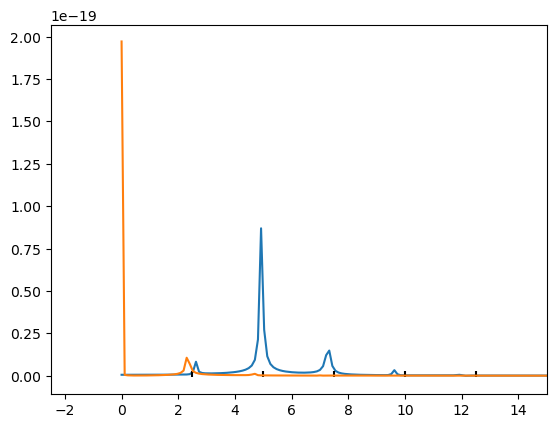

In [514]:
# Plot inspiral fft
inspiral = np.where(hp.sample_times <= -135)
inspiral_ts = timeseries.TimeSeries(hp[inspiral], np.mean(np.diff(t)), epoch=t[0])
inspiral_fs = inspiral_ts.to_frequencyseries()
plt.plot(inspiral_fs.sample_frequencies, np.abs(inspiral_fs))

# Plot mode position
modes = np.array([1,2,3,4,5])
plt.vlines(modes*f_low/2, -0.1e-20, 0.3e-20, colors='k')

# Plot inspiral envelope fft
inspiral_env_ts = timeseries.TimeSeries(np.sqrt(hp[inspiral]**2+hc[inspiral]**2), np.mean(np.diff(t)), epoch=t[0])
inspiral_env_fs = inspiral_env_ts.to_frequencyseries()
plt.plot(inspiral_env_fs.sample_frequencies, np.abs(inspiral_env_fs))

# Zoom in
plt.xlim(-2.5,15)
#plt.ylim(-0.01e-16,0.05e-16)

(-1e-16, 5e-17)

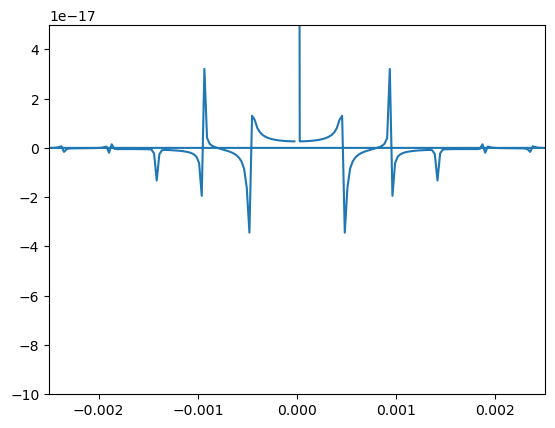

In [470]:
# inspiral = np.where(hp.sample_times <= -150)
hp_fft = compute_fft(hp.sample_times[inspiral], np.sqrt(hp[inspiral]**2+hc[inspiral]**2))
plt.plot(hp_fft[0], hp_fft[1])
# mode_pos = np.abs(hp_fft[0][np.argmax(np.abs(hp_fft[1]))])/2
# modes = np.array([-5,-4,-3,-2,-1,1,2,3,4,5])
#plt.vlines(modes*mode_pos, -0.1e-16, 0.1e-16, colors='k')
plt.xlim(-0.0025,0.0025)
plt.ylim(-1e-16,0.5e-16)

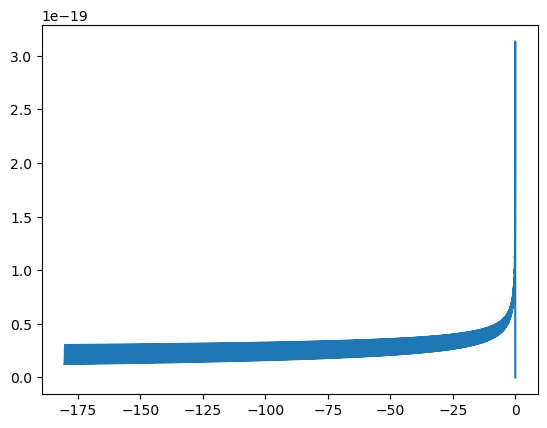

In [471]:
plt.plot(hp.sample_times, np.sqrt(hp**2+hc**2))
#plt.xlim(-1,-0.5)